In [1]:
import numpy as np
from distance import *
from MCMC import * 
import pandas as pd
import matplotlib.pyplot as pl

- Data: $X_i \equiv (\mu_i, z_i)$

- Cosmological parameters: ${\Omega} = {\Omega_{\Lambda}, \Omega_{m}, \Omega_{k}}$

- Likelihood: $$P( \vec X| \Omega_m, \Omega_{\Lambda}, \Omega_k) \propto \exp \left( -\frac{1}{2}\Delta \vec \mu \cdot C^{-1} \cdot \Delta \vec \mu\right)$$

where
$\Delta  \mu_{i} = \mu_{i} -  \mu_{model}(z_i; \Omega)$

In [32]:
#loading data
data=pd.read_csv('lcparam_DS17f.txt',delimiter=' ')
cov_data = np.array(pd.read_csv('sys_DS17f.txt'))

# create numpy version data
red_shift_data = (data['zcmb']).to_numpy()
apparent_magnitude_data = (data['mb']).to_numpy() 
apparent_magnitude_standard_errors = (data['dmb']).to_numpy()
stat_cov = np.diag(apparent_magnitude_standard_errors**2.)
sys_cov = cov_data.reshape(40, 40)
cov_matrix = stat_cov + sys_cov

inv_cov= 1000 * np.linalg.inv(cov_matrix*1000)





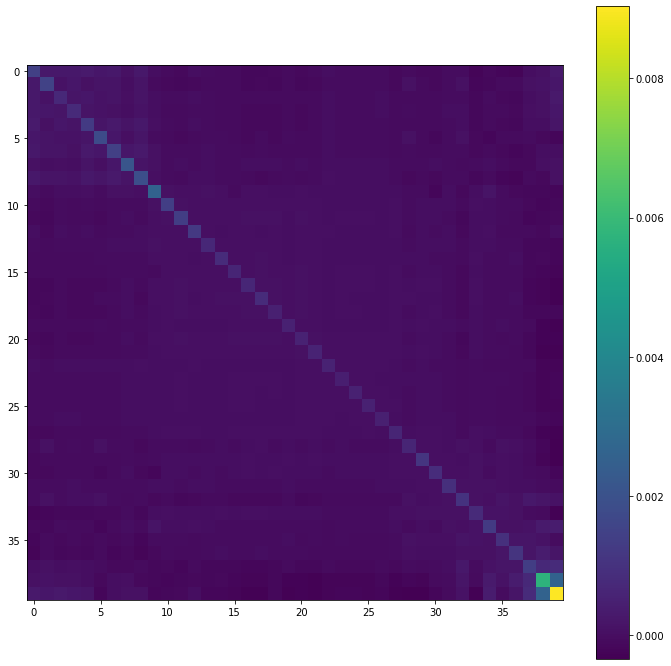

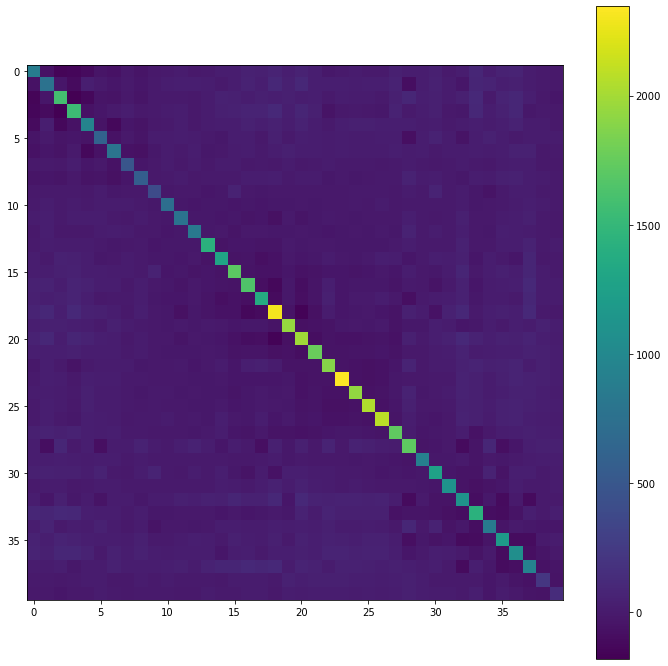

In [33]:
pl.figure(figsize=(12,12))
pl.imshow(cov_matrix)
pl.colorbar()

pl.figure(figsize=(12,12))
pl.imshow(inv_cov)
pl.colorbar()


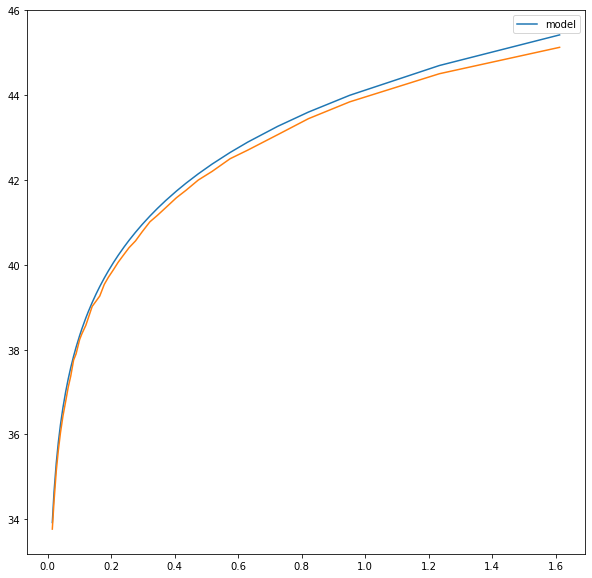

In [34]:

mu_model = distance_modulus(red_shift_data,.286,.714,69.6,1E2)
M = -19.2

pl.figure(figsize=(10,10))
pl.plot(red_shift_data,mu_model,label='model')
pl.plot(red_shift_data,apparent_magnitude_data-M)
pl.legend()

In [37]:
pars_label = [r'$\Omega_m$',r'$\Omega_{\Lambda}$',r'$H_0$']
Omegas = [0.3,0.7,70]
cov_gen = np.diag([0.1**2.,0.1**2.,5**2.])
chain = run_MCMC(red_shift_data,apparent_magnitude_data,cov_matrix,Omegas,cov_gen,nsteps=10000)


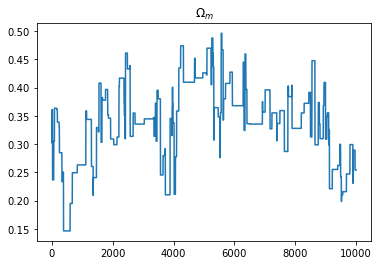

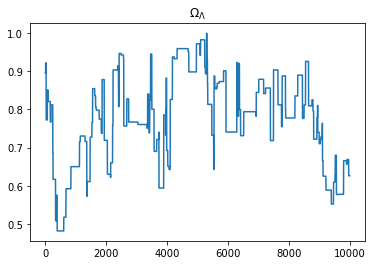

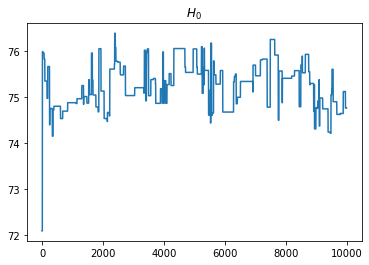

In [38]:
for i in range(chain.shape[1]):
    pl.figure()
    
    c = chain[:,i]
    n = range(chain.shape[0])
    pl.title(pars_label[i])
    pl.plot(n,c)
    

In [10]:
np.isnan([np.nan,0]).any()

True

In [14]:
x = distance_modulus(0.3,-286,.714,69.6,1E2)
np.isnan([x,0]).any()

True

(array([13., 12., 10.,  7.,  9., 11.,  8., 12., 11.,  7.]),
 array([0.01647287, 0.11350609, 0.21053931, 0.30757253, 0.40460575,
        0.50163897, 0.59867219, 0.69570541, 0.79273863, 0.88977185,
        0.98680508]),
 <BarContainer object of 10 artists>)

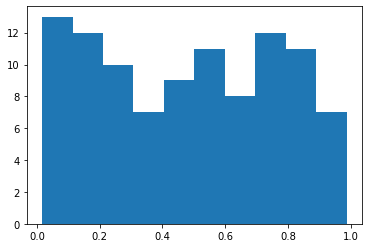

In [19]:
pl.hist(np.random.uniform(0,1,size=100))